# __DataCrohn__

__Autores__: Aline Silva dos Santos, Jônatas Rafael de Oliveira Melo e Letícia Nunes de Souza Andrade.

## Introdução

A Doença de Crohn é uma condição inflamatória crônica do trato gastrointestinal, cuja etiologia envolve fatores genéticos, imunológicos e ambientais. Identificar padrões de expressão gênica associados à doença pode contribuir tanto para o diagnóstico precoce quanto para a estratificação de risco de pacientes, oferecendo compreensões valiosas para pesquisas biomédicas e possíveis intervenções terapêuticas.

Foram adotados seis modelos de aprendizado supervisionado para a tarefa de classificação: Dummy (baseline), Naive Bayes, Regressão Logística, SVM, Random Forest e XGBoost. Essa seleção permitiu que fossem avaliadas a robustez preditiva, a interpretabilidade e a complexidade de aprendizado, aspectos essenciais em contextos clínicos.

A avaliação do desempenho dos modelos é realizada com base em métricas clássicas de classificação, destacando-se a AUC-ROC, que reflete a capacidade do modelo em distinguir entre as classes positivas e negativas, e o desvio padrão, que indica a estabilidade da previsão entre diferentes execuções. Além disso, estratégias de validação cruzada e otimização de hiperparâmetros via Optuna foram empregadas para assegurar a robustez e a generalização dos resultados.

Este estudo visa, portanto, não apenas apresentar um modelo preditivo de alta performance, mas também fornecer percepções interpretáveis sobre padrões de expressão gênica relacionados à Doença de Crohn, promovendo um entendimento mais aprofundado da biologia da doença e contribuindo para futuras investigações clínicas.


## Metodologia

### 0. Importando bibliotecas

In [265]:
# Tratamento de dados
import pandas as pd
import numpy as np
from collections import Counter

# Aprendizado de máquina
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, make_scorer
import joblib

# Otimização de hiperparâmetros
import optuna
import optuna.visualization as oviz
from optuna.samplers import TPESampler

# Visualização gráfica
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go

### 1.Tratamento de dados

Este projeto foca na construção de um modelo preditivo supervisionado utilizando o conjunto de dados E-GEOD-101794, proveniente do repositório GEO. O objetivo central é induzir um modelo de classificação binária capaz de distinguir amostras de pacientes com Doença de Crohn ($y=1$) de controles não inflamatórios ($y=0$). As features ($X$) para esta tarefa são compostas pela expressão de 65.217 genes, complementadas por metadados clínicos cruciais, como idade e sexo.

Nesta etapa será realizada a preparação dos dados, passo crucial capaz de transformar os dados brutos e incompatíveis em um formato estruturado e limpo que os algoritmos de Aprendizado de Máquina exigem.

#### 1.1 Carregamento e Inspeção dos Dados:

Carregamento e Inspeção dos dados - Para garantir que todos os dados estão acessíveis.

In [266]:
dados_1 = "E-GEOD-101794-raw-counts.tsv"
dados_2 = "E-GEOD-101794-experiment-design.tsv"
dados_3 = "E-GEOD-101794-analytics.tsv"

# Carregar os DataFrames
df1 = pd.read_csv(dados_1, sep="\t")
df2 = pd.read_csv(dados_2, sep="\t")
df3 = pd.read_csv(dados_3, sep="\t")

# Inspeção dos Dados

# Contagens
print(f"\n[df1] Dimensões: {df1.shape}")
print("Primeiras linhas do df1:")
print(df1.head())

# Metadados
print(f"\n[df2] Dimensões: {df2.shape}")
print("Primeiras linhas do df2:")
print(df2[['Run', 'Sample Characteristic[disease]', 'Sample Characteristic[age at diagnosis]']].head())

# Resultados Estatísticos
print(f"\n[df3] Dimensões: {df3.shape}")
print("Primeiras linhas e colunas relevantes do df3:")
print(df3.iloc[:, :6].head(3))

# Verificação do número de amostras (Instâncias)
num_amostras_df1 = df1.shape[1] - 2  # Subtrai 'Gene ID' e 'Gene Name'
num_amostras_df2 = df2.shape[0]

print()
print(f"Amostras em df1: {num_amostras_df1}")
print(f"Amostras em df2: {num_amostras_df2}")

if num_amostras_df1 == num_amostras_df2:
    print("\nAs dimensões de amostra parecem consistentes para o merge.")
else:
    print("\nALERTA: O número de amostras não coincide. Uma verificação de quais amostras estão faltando será necessária no merge.")

# Armazenando o número de genes (features brutas)
num_genes = df1.shape[0]
print(f"Número de Features (Genes) Brutas: {num_genes}")


[df1] Dimensões: (65217, 306)
Primeiras linhas do df1:
           Gene ID Gene Name  SRR5861974  SRR5861975  SRR5861976  SRR5861977  \
0  ENSG00000000003    TSPAN6         385         809         251         873   
1  ENSG00000000005      TNMD           0           2           4           0   
2  ENSG00000000419      DPM1         292         300         182         482   
3  ENSG00000000457     SCYL3         122         146          64         329   
4  ENSG00000000460  C1orf112          12          37          27         111   

   SRR5861978  SRR5861979  SRR5861980  SRR5861981  ...  SRR5862268  \
0         644         460         498         308  ...         405   
1           1           5           3           1  ...           3   
2         289         227         369         229  ...         283   
3         242         150         315         136  ...         225   
4          28          42          99          48  ...          75   

   SRR5862269  SRR5862270  SRR5862271  SRR

#### 1.2 Preparo da Matriz de Features Brutas ($X$)

Preparo da Matriz de Features Brutas (Transposição) - Mudança do formato de Genes x Amostras para Amostras x Genes (o formato esperado pelos modelos).

In [267]:
# Colunas de identificação e contagem
colunas_id = ['Gene ID', 'Gene Name']
colunas_contagem = [col for col in df1.columns if col not in colunas_id]

# Transposição e Indexação
df1_transposto = df1[colunas_contagem].T 

# Renomeando o Índice 
# O novo índice agora são os IDs das amostras (SRR...)
df1_transposto.index.name = 'Run' 

# Vamos usar o 'Gene ID' para renomear as colunas após a transposição
gene_ids = df1['Gene ID']
df1_transposto.columns = gene_ids

print(f"Dimensões da Matriz de Features Brutas (Amostras x Genes): {df1_transposto.shape}")
print()
print("Após transposição:")
print()
print(df1_transposto.iloc[:, :5].head())

Dimensões da Matriz de Features Brutas (Amostras x Genes): (304, 65217)

Após transposição:

Gene ID     ENSG00000000003  ENSG00000000005  ENSG00000000419  \
Run                                                             
SRR5861974              385                0              292   
SRR5861975              809                2              300   
SRR5861976              251                4              182   
SRR5861977              873                0              482   
SRR5861978              644                1              289   

Gene ID     ENSG00000000457  ENSG00000000460  
Run                                           
SRR5861974              122               12  
SRR5861975              146               37  
SRR5861976               64               27  
SRR5861977              329              111  
SRR5861978              242               28  


#### 1.3 Preparação do Target ($y$) e Metadados

 Preparação do Target ($y$) e Metadados - Converte rótulos textuais (Crohn's disease) em numéricos (0/1) e limpa as features de metadados (Idade, Sexo).

In [268]:
# Seleciona as colunas a serem tratadas do df2
df = df2[['Run', 'Sample Characteristic[disease]', 
                          'Sample Characteristic[age at diagnosis]', 
                          'Sample Characteristic[sex]']].copy()

# Tranformações necessárias

# Codificação Binária para 'disease' (Target (y))
df.loc[:, 'Is_Crohns_Disease'] = (
    df['Sample Characteristic[disease]'] == "Crohn's disease").astype(int)

# Tratamento das Features: limpeza de Texto para 'age' e codificação categórica para 'sex'
df.loc[:, 'Patient_Age_Years'] = (
    df['Sample Characteristic[age at diagnosis]']
    .str.replace(' year', '', regex=False) # regex=False para otimização, já que o padrão é fixo
    .astype(float)
)

df.loc[:, 'Patient_Sex_Encoded'] = (
    df['Sample Characteristic[sex]']
    .astype('category') 
    .cat
    .codes
) # Se o output for {0: 'female', 1: 'male'}, sabemos que 0=female e 1=male


# Indexação e Seleção de Colunas Finais
df_final = df.set_index('Run')[['Is_Crohns_Disease', 'Patient_Age_Years', 'Patient_Sex_Encoded']]


# Pré-processamento dos metadados concluído:
print(f"Dimensões do DF de Metadados Final: {df_final.shape}")
print()
print(df_final.head())
print("\nVerificação do Balanceamento do Target (y):")
print(df_final['Is_Crohns_Disease'].value_counts())

Dimensões do DF de Metadados Final: (304, 3)

            Is_Crohns_Disease  Patient_Age_Years  Patient_Sex_Encoded
Run                                                                  
SRR5861974                  1                6.6                    1
SRR5861975                  1                6.8                    0
SRR5861976                  1                7.3                    0
SRR5861977                  1                7.8                    0
SRR5861978                  1                8.0                    0

Verificação do Balanceamento do Target (y):
Is_Crohns_Disease
1    254
0     50
Name: count, dtype: int64


#### 1.4 Alinhamento de amostras (Merge Final)

 Merge Final - Alinha a expressão gênica bruta de cada amostra com seu rótulo de diagnóstico e suas características clínicas.

In [269]:
#Execuntando o alinhamento final e unificando os DataFrames

# Realiza o merge usando o índice ('Run') de ambos os DataFrames
df_final_unificado = df1_transposto.merge(
    df_final, 
    left_index=True, 
    right_index=True, 
    how='inner' # Garante que apenas amostras presentes em ambos os DFs permaneçam
)

print(f"Dimensões do DataFrame Final (Amostras x Features Totais): {df_final_unificado.shape}")
print()
colunas = df_final_unificado.columns[:5].tolist() + df_final_unificado.columns[-3:].tolist()
print(df_final_unificado[colunas].head())

# Separação de X (Features) e y (Target)
X_features = df_final_unificado.drop(columns=['Is_Crohns_Disease'])
y_target = df_final_unificado['Is_Crohns_Disease']

print(f"\nMatriz de Features Final (X) com: {X_features.shape[1]} colunas.")
print(f"Vetor Target (y_target) com: {y_target.shape[0]} exemplos.")
print()
df_final_unificado.iloc[:, :5]


Dimensões do DataFrame Final (Amostras x Features Totais): (304, 65220)

            ENSG00000000003  ENSG00000000005  ENSG00000000419  \
Run                                                             
SRR5861974              385                0              292   
SRR5861975              809                2              300   
SRR5861976              251                4              182   
SRR5861977              873                0              482   
SRR5861978              644                1              289   

            ENSG00000000457  ENSG00000000460  Is_Crohns_Disease  \
Run                                                               
SRR5861974              122               12                  1   
SRR5861975              146               37                  1   
SRR5861976               64               27                  1   
SRR5861977              329              111                  1   
SRR5861978              242               28                  1   

 

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460
Run,,,,,
SRR5861974,385,0,292,122,12
SRR5861975,809,2,300,146,37
SRR5861976,251,4,182,64,27
SRR5861977,873,0,482,329,111
SRR5861978,644,1,289,242,28
...,...,...,...,...,...
SRR5862273,296,0,302,188,85
SRR5862274,550,3,378,258,52
SRR5862275,457,2,325,175,52


#### 1.5 Normalização e Transformação Logarítmica dos dados

 Tranformação Logarítimica- O logaritmo comprime os valores mais altos, trazendo a distribuição para algo mais próximo da normal (Gaussiana). Isso evita que modelos sejam dominados por alguns outliers de alta expressão. Ou seja, melhora a distribuição estatística e trata a natureza multiplicativa dos dados biológicos.


In [270]:
metadados = ['Patient_Age_Years', 'Patient_Sex_Encoded'] 
colunas_genes = X_features.columns.drop(metadados).tolist()

# Transformação Logarítmica 

# Aplicação do Log2(x + 1) apenas nas contagens de genes (reduz o peso de genes com expressão muito alta).
X_contagem_genes = X_features[colunas_genes].copy()
X_transformacao_log = np.log2(X_contagem_genes + 1)

# Reconstrução da Matriz (Log-Transformada + Metadados)
df_transformacao_log = pd.concat([
    X_transformacao_log, 
    X_features[metadados]
], axis=1)

print(f"Dimensões do DF Log-Transformado: {df_transformacao_log.shape}")

# Normalização dos dados

scaler = MinMaxScaler()
X_array_normalizado = scaler.fit_transform(df_transformacao_log[colunas_genes])

# Recriando o DataFrame Normalizado 
df_X_normalizado = pd.DataFrame(X_array_normalizado, 
                                columns=colunas_genes, 
                                index=df_transformacao_log.index)

# Reconstrução Final (Features normalizadas + metadados)
df_final_normalizado = pd.concat([
    df_X_normalizado,               # colunas de genes normalizadas
    df_transformacao_log[metadados] # colunas de metadados
], axis=1)

print(f"Dimensões do DF Final Normalizado e Log-Transformado: {df_final_normalizado.shape}")

Dimensões do DF Log-Transformado: (304, 65219)
Dimensões do DF Final Normalizado e Log-Transformado: (304, 65219)


#### 1.6 Redimensionamento dos dados


Normalização - Remove as diferenças de magnitude. Todos os genes e metadados log-transformados irão variar de forma igual, tipicamente entre 0 e 1.


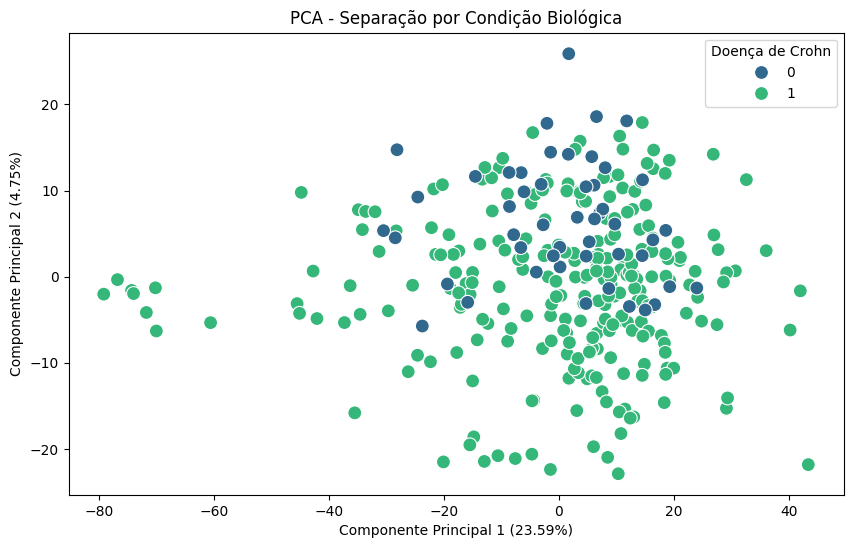

In [271]:
# Aplicação do PCA

X_pca_entrada = df_final_normalizado[colunas_genes]

pca = PCA(n_components=2)
componentes_principais = pca.fit_transform(X_pca_entrada)
df_pca = pd.DataFrame(data=componentes_principais, 
                      columns=['PC1', 'PC2'],
                      index=X_pca_entrada.index)

# Adicição do Target (y)
df_pca['Is_Crohns_Disease'] = y_target # Para colorir os pontos no gráfico conforme a condição biológica

# Plotagem (Visualização da Separação por Doença)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', 
                hue='Is_Crohns_Disease', 
                data=df_pca, 
                palette='viridis', 
                s=100)
plt.title('PCA - Separação por Condição Biológica')
plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.legend(title='Doença de Crohn')
plt.show()

__1.6.1 Aplicação do PCA 3D__


PCA - Empregado para reduzir a dimensionalidade do espaço das features para duas ou três componentes principais, facilitando a visualização e identificando os vetores de maior variância.


In [272]:
# PCA 3D (PLotagem Interativa)

# Renderização para a plotagem adequada do gráfico
pio.renderers.default = "iframe"

pca_3d = PCA(n_components=3)
principais_componentes_3d = pca_3d.fit_transform(df_final_normalizado[colunas_genes])

df_pca_3d = pd.DataFrame(data=principais_componentes_3d, 
                         columns=['PC1', 'PC2', 'PC3'],
                         index=df_final_normalizado.index)

# Garantir que o Target é numérico (0 ou 1) para o colorscale
df_pca_3d['Is_Crohns_Disease'] = y_target.astype(int) 

# Cria a figura Scatter3d (UMA ÚNICA TRACE)
fig = go.Figure(data=[go.Scatter3d(
    x=df_pca_3d['PC1'],
    y=df_pca_3d['PC2'],
    z=df_pca_3d['PC3'],
    mode='markers', 
    marker=dict(
        size=5,
        color=df_pca_3d['Is_Crohns_Disease'], 
        colorscale='Viridis',
        opacity=0.8,
        # Adicionar colorbar_title ajuda a entender as cores
        colorbar=dict(title='Doença de Crohn (1=Sim, 0=Não)') 
    )
)])

# Configurações de Layout
fig.update_layout(
    title=f'PCA 3D (Log-Normalizado) - Explica {pca_3d.explained_variance_ratio_.sum()*100:.2f}% da Variância',
    width=1000,
    height=800,
    scene=dict(
        xaxis=dict(title=f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.2f}%)'),
        yaxis=dict(title=f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.2f}%)'),
        zaxis=dict(title=f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.2f}%)'),
        aspectmode='data'))

fig.show()

#### 1.7 Seleção de Features

 Seleção de Features (Usando o df3/analytics.tsv) - Filtra os genes, criando um dataset final reduzido e otimizado (df_tratado) para a modelagem. A Seleção de Features é essencial para reduzir a dimensionalidade, mantendo genes significativos que atendem a $|\text{Log2FC}| \geq 1.0$ (significância biológica) e $\text{P-value} < 0.05$ (significância estatística) em pelo menos um subtipo (A1a ou A1b), preparando o conjunto final para os modelos.

In [273]:
# Seleção de Features (Usando o df3/analytics.tsv)

LOG2FC_CORTE = 1.0 
P_VAL_CORTE = 0.05

# Nomes das colunas do df3 (Analytics TSV) 
print(f"Nomes das colunas do df3 (Analytics TSV): {df3.columns.tolist()}")
P_VAL_A1A = "'Crohn's disease' vs 'non inflammatory bowel disease control' in 'A1a Paris classification'.p-value"
LOG_FC_A1A = "'Crohn's disease' vs 'non inflammatory bowel disease control' in 'A1a Paris classification'.log2foldchange"
P_VAL_A1B = "'Crohn's disease' vs 'non inflammatory bowel disease control' in 'A1b Paris classification'.p-value"
LOG_FC_A1B = "'Crohn's disease' vs 'non inflammatory bowel disease control' in 'A1b Paris classification'.log2foldchange"
print()

# Aplica o filtro: Genes com p-value baixo e |Log2FC| alto em A1a ou em A1b
filter_a1a = (
    (df3[P_VAL_A1A] < P_VAL_CORTE) & 
    (df3[LOG_FC_A1A].abs() >= LOG2FC_CORTE)
)
filter_a1b = (
    (df3[P_VAL_A1B] < P_VAL_CORTE) & 
    (df3[LOG_FC_A1B].abs() >= LOG2FC_CORTE)
)

# Seleciona as linhas que passaram no filtro
genes_relevantes = df3[filter_a1a | filter_a1b]
genes_selecionados = genes_relevantes['Gene ID'].tolist()

print(f"Número de Features Brutas (Log/Normalizadas): {len(colunas_genes)}")
print(f"Número de Genes Selecionados (Após filtragem): {len(genes_selecionados)}")

# Cria a lista final de features (Genes selecionados + Metadados clínicos)
coluna_final = genes_selecionados + metadados

# Aplica a seleção no DF final normalizado (df_final_normalizado)
df_tratado = df_final_normalizado[coluna_final]

print(f"\nDimensões do DataFrame Final Pronto para Split/Treinamento: {df_tratado.shape}")

Nomes das colunas do df3 (Analytics TSV): ['Gene ID', 'Gene Name', "'Crohn's disease' vs 'non inflammatory bowel disease control' in 'A1a Paris classification'.p-value", "'Crohn's disease' vs 'non inflammatory bowel disease control' in 'A1a Paris classification'.log2foldchange", "'Crohn's disease' vs 'non inflammatory bowel disease control' in 'A1b Paris classification'.p-value", "'Crohn's disease' vs 'non inflammatory bowel disease control' in 'A1b Paris classification'.log2foldchange"]

Número de Features Brutas (Log/Normalizadas): 65217
Número de Genes Selecionados (Após filtragem): 1920

Dimensões do DataFrame Final Pronto para Split/Treinamento: (304, 1922)


### 2. Modelagem preditiva

Após a etapa de pré-processamento dos dados, foi dado prosseguimento à análise preditiva. Nessa fase, buscou-se avaliar o desempenho de diferentes algoritmos de aprendizado de máquina na classificação dos dados relacionados à doença de Crohn.

##### 2.1 Definindo os modelos

Foram testados seis algoritmos diferentes: um modelo base (baseline) e cinco modelos supervisionados com princípios distintos de aprendizado.

Os algoritmos utilizados foram:

- Dummy Classifier: usado como baseline, ou seja, como ponto de comparação. Esse modelo não “aprende” com os dados, ele apenas prevê sempre a classe mais comum ou faz previsões aleatórias. Serve para verificar se os outros modelos realmente estão identificando padrões úteis.

- Regressão Logística: modelo linear que estima a probabilidade de um paciente ter a doença de Crohn com base nas variáveis analisadas. Além de ser simples e rápido, permite entender como cada variável influencia o resultado.

- Random Forest: conjunto de várias árvores de decisão que trabalham juntas para melhorar as previsões. Esse modelo consegue lidar bem com relações mais complexas e não lineares entre as variáveis, além de mostrar quais delas têm mais importância para a classificação.

- SVM (Máquina de Vetores de Suporte): separa as classes encontrando a melhor fronteira possível entre elas. É especialmente útil em conjuntos de dados com muitas variáveis, como é comum em estudos clínicos ou genéticos.

- Naive Bayes: modelo baseado em probabilidades, que parte da ideia de que as variáveis são independentes entre si. Mesmo sendo simples, costuma funcionar bem em muitos casos e fornece estimativas probabilísticas claras.

- XGBoost: modelo mais avançado baseado em árvores de decisão. Ele combina várias árvores menores, corrigindo os erros das anteriores, o que o torna muito eficiente para detectar padrões complexos e lidar com dados desbalanceados.

Essa variedade de algoritmos foi usada para comparar diferentes formas de aprendizado, desde as mais simples e lineares até as mais complexas, e identificar quais delas melhor se ajustam às características dos dados analisados.

In [274]:
models = {
    'Baseline_Dummy': DummyClassifier(strategy='most_frequent', random_state=42),

    'RandomForest': RandomForestClassifier(
        n_estimators=200, random_state=42, class_weight='balanced'
    ),

    'NaiveBayes': GaussianNB(),

    'SVM': SVC(
        kernel='rbf', probability=True, class_weight='balanced', random_state=42
    ),

    'XGBoost': XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42
    ),

    'LogisticRegression': LogisticRegression(
        solver='liblinear',
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    )
}

##### 2.2 Estrutura da Validação Cruzada e Métrica

Foi definida uma validação cruzada estratificada de cinco partições, garantindo que a proporção entre classes fosse mantida em cada subdivisão.

A métrica AUC-ROC foi selecionada por avaliar a capacidade do modelo em distinguir entre indivíduos doentes e não doentes, mesmo em conjuntos desbalanceados.

A normalização das variáveis foi incluída para evitar distorções causadas por escalas diferentes entre os atributos.

In [275]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaler = StandardScaler()

def auc_scorer(estimator, X, y):
    try:
        # tenta usar predict_proba
        y_proba = estimator.predict_proba(X)[:, 1]
    except AttributeError:
        # se não tiver predict_proba, tenta decision_function
        y_proba = estimator.decision_function(X)
    # se houver apenas uma classe no fold, retorna np.nan
    if len(np.unique(y)) < 2:
        return np.nan
    return roc_auc_score(y, y_proba)

##### 2.3 Definição de X e y

O código separa a variável-alvo (``Is_Crohns_Disease``) das variáveis preditoras e divide o conjunto de dados em 80% para treino e 20% para teste, garantindo aleatoriedade e reprodutibilidade dos resultados.

In [276]:
y = df_final['Is_Crohns_Disease']
X = df_tratado
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=500)

##### 2.4 Execução da Validação Cruzada Estratificada

A validação cruzada estratificada garante que a distribuição das classes da variável de saída seja igual em todas as divisões de validação (folds). Essa técnica evita que uma classe fique sub-representada em alguma divisão, aumentando a confiabilidade das métricas de performance.

In [277]:
results_raw = {}

for name, model in models.items():
    print(f"Treinando e avaliando modelo: {name}...")
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    scores = cross_val_score(
        pipeline, X, y,
        cv=outer_cv,
        scoring=auc_scorer,  # usamos a função personalizada
        n_jobs=-1
    )
    
    # limpar NaNs (caso algum fold tenha falhado)
    valid_scores = [s for s in scores if not np.isnan(s)]

    results_raw[name] = {
        'Média': np.mean(valid_scores),
        'Desvio Padrão': np.std(valid_scores)
    }

# Converter em DataFrame
results_raw = pd.DataFrame(results_raw).T
results_raw.index.name = 'Modelo'
results_raw.columns.name = None

print("\nResultados de Validação Cruzada (AUC-ROC):")
display(results_raw)


Treinando e avaliando modelo: Baseline_Dummy...
Treinando e avaliando modelo: RandomForest...
Treinando e avaliando modelo: NaiveBayes...
Treinando e avaliando modelo: SVM...
Treinando e avaliando modelo: XGBoost...
Treinando e avaliando modelo: LogisticRegression...

Resultados de Validação Cruzada (AUC-ROC):


,Média,Desvio Padrão
Modelo,,
Baseline_Dummy,0.500000,0.000000
RandomForest,0.971467,0.020977
NaiveBayes,0.853659,0.035615
SVM,0.988580,0.010107
XGBoost,0.980361,0.014383
LogisticRegression,0.992525,0.007477


##### 2.5 Execução da Validação Cruzada Aninhada

A Validação Cruzada Aninhada usa duas validações cruzadas: uma interna para otimizar hiperparâmetros e uma externa para estimar o erro de generalização. Isso garante uma avaliação de performance mais imparcial e confiável, evitando vieses na seleção de hiperparâmetros.

O processo de validação cruzada aninhada foi executado para cada modelo.
Em cada iteração, o conjunto de dados foi dividido em partições para treino e teste, sendo as amostras escalonadas dentro do pipeline.

Os valores médios e desvios padrão da métrica AUC-ROC foram calculados e armazenados, representando o desempenho geral de cada modelo.

In [278]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)  # inner é usado em tuning, mas deixamos pronto

results_cv = {}

# Loop principal
for name, model in models.items():
    print(f"\nTreinando modelo: {name}...")

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # nested cross-validation (sem otimização interna ainda)
    nested_scores = cross_val_score(
        pipeline,
        X, y,
        cv=outer_cv,
        scoring=auc_scorer,
        n_jobs=-1
    )

    # Limpa NaNs se algum fold falhou
    nested_scores = [s for s in nested_scores if not np.isnan(s)]

    # Salva resultados em formato compatível com o gráfico
    results_cv[name] = {
        'Média': np.mean(nested_scores),
        'Desvio Padrão': np.std(nested_scores)
    }

    print(f"{name} - AUC-ROC médio: {np.mean(nested_scores):.4f} ± {np.std(nested_scores):.4f}")

# Converter para DataFrame
results_cv = pd.DataFrame(results_cv).T
results_cv.index.name = 'Modelo'
results_cv.columns.name = None

print("\nResultados de Nested CV (AUC-ROC):")
display(results_cv)



Treinando modelo: Baseline_Dummy...
Baseline_Dummy - AUC-ROC médio: 0.5000 ± 0.0000

Treinando modelo: RandomForest...
RandomForest - AUC-ROC médio: 0.9715 ± 0.0210

Treinando modelo: NaiveBayes...
NaiveBayes - AUC-ROC médio: 0.8537 ± 0.0356

Treinando modelo: SVM...
SVM - AUC-ROC médio: 0.9886 ± 0.0101

Treinando modelo: XGBoost...
XGBoost - AUC-ROC médio: 0.9804 ± 0.0144

Treinando modelo: LogisticRegression...
LogisticRegression - AUC-ROC médio: 0.9925 ± 0.0075

Resultados de Nested CV (AUC-ROC):


,Média,Desvio Padrão
Modelo,,
Baseline_Dummy,0.500000,0.000000
RandomForest,0.971467,0.020977
NaiveBayes,0.853659,0.035615
SVM,0.988580,0.010107
XGBoost,0.980361,0.014383
LogisticRegression,0.992525,0.007477


##### 2.6 Otimização de Hiperparâmetros com Optuna

__2.6.1 Configurações gerais do tuning__

Foram definidas as configurações globais do processo de otimização: número de trials, folds para CV, sampler TPE com seed fixa e cálculo do ``scale_pos_weight`` global para uso no XGBoost.

In [279]:
random_state = 42
print("Optuna versão:", optuna.__version__)

Optuna versão: 4.5.0


In [280]:
n_trials = 100  # número de trials por modelo
cv_folds = 5    # número de folds para validação cruzada dentro do objective
sampler = TPESampler(seed=random_state)
scoring = 'roc_auc'
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

__2.6.2 Função objective (uma por modelo)__

Funções objetivo foram definidas para Logistic Regression, Random Forest, Naive Bayes, SVM e XGBoost. Em cada função, o espaço de busca de hiperparâmetros foi especificado via ``trial.suggest_`` e o modelo foi avaliado por validação cruzada estratificada, retornando a média da AUC-ROC calculada nos folds.

In [281]:
def objective_logistic(trial):
    C = trial.suggest_float("C", 1e-4, 1e2, log=True)
    penalty = trial.suggest_categorical("penalty", ["l2", "l1"])
    # solver 'saga' suporta l1 e l2
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(C=C, penalty=penalty, solver="saga", max_iter=20000, class_weight="balanced", random_state=random_state))
    ])
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return float(np.mean(scores))


def objective_rf(trial):
    n_estimators = trial.suggest_categorical("n_estimators", [100, 200, 500, 800])
    max_depth = trial.suggest_categorical("max_depth", [None, 5, 10, 20, 40])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    model = Pipeline([
        ("clf", RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                       min_samples_split=min_samples_split, class_weight="balanced",
                                       n_jobs=-1, random_state=random_state))
    ])
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return float(np.mean(scores))


def objective_nb(trial):
    var_smoothing = trial.suggest_float("var_smoothing", 1e-12, 1e-6, log=True)
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", GaussianNB(var_smoothing=var_smoothing))
    ])
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return float(np.mean(scores))


def objective_svm(trial):
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf"])
    if kernel == "rbf":
        gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
    else:
        gamma = "scale"
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(C=C, kernel=kernel, gamma=gamma, probability=True, class_weight="balanced", random_state=random_state))
    ])
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return float(np.mean(scores))


def objective_xgb(trial):
    counts = Counter(y)
    scale_pos_weight_global = counts[0] / counts[1]
    
    n_estimators = trial.suggest_categorical("n_estimators", [100, 200, 300, 500])
    max_depth = trial.suggest_int("max_depth", 3, 10)
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-0, log=True)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    # usar scale_pos_weight_global calculado previamente
    model = Pipeline([
        ("clf", XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,
                              subsample=subsample, colsample_bytree=colsample_bytree,
                              scale_pos_weight=scale_pos_weight_global,
                              eval_metric="auc", random_state=random_state, n_jobs=1))
    ])
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return float(np.mean(scores))


__2.6.3 Executar os estudos Optuna (um estudo por modelo)__

Foram executados estudos separados do Optuna para cada modelo, cada um realizando 100 trials. Os melhores hiperparâmetros e valores de AUC-ROC foram armazenados e exportados para `.db` para posterior consulta.

---

>Para efeito de melhor experiência do usuário, a célula abaixo está mantida na forma de `markdown`, mas os resultados permanecem disponíveis para visualização no repositório do GitHub em que esse notebook se encontra.

```python
# Logistic Regression
studies = {}
best_params = {}
best_values= {}
study_log = optuna.create_study(
    direction="maximize",
    sampler=sampler,
    study_name="logistic_regression",
    storage="sqlite:///logistic_regression.db",
    load_if_exists=True
)
study_log.optimize(objective_logistic, n_trials=n_trials, n_jobs=1)
studies['Logistic'] = study_log
best_params['Logistic'] = study_log.best_params
best_values['Logistic'] = study_log.best_value
print("Logistic best AUC:", study_log.best_value)

# Random Forest
study_rf = optuna.create_study(
    direction="maximize",
    sampler=sampler,
    study_name="random_forest",
    storage="sqlite:///random_forest.db",
    load_if_exists=True
)
study_rf.optimize(objective_rf, n_trials=n_trials, n_jobs=1)
studies['RandomForest'] = study_rf
best_params['RandomForest'] = study_rf.best_params
best_values['RandomForest'] = study_rf.best_value
print("RandomForest best AUC:", study_rf.best_value)


# Naive Bayes
study_nb = optuna.create_study(
    direction="maximize",
    sampler=sampler,
    study_name="naive_bayes",
    storage="sqlite:///naive_bayes.db",
    load_if_exists=True
)
study_nb.optimize(objective_nb, n_trials=n_trials, n_jobs=1)
studies['NaiveBayes'] = study_nb
best_params['NaiveBayes'] = study_nb.best_params
best_values['NaiveBayes'] = study_nb.best_value
print("NaiveBayes best AUC:", study_nb.best_value)


# SVM
study_svm = optuna.create_study(
    direction="maximize",
    sampler=sampler,
    study_name="svm",
    storage="sqlite:///svm.db",
    load_if_exists=True
)
study_svm.optimize(objective_svm, n_trials=n_trials, n_jobs=1)
studies['SVM'] = study_svm
best_params['SVM'] = study_svm.best_params
best_values['SVM'] = study_svm.best_value
print("SVM best AUC:", study_svm.best_value)


# XGBoost
study_xgb = optuna.create_study(
    direction="maximize",
    sampler=sampler,
    study_name="xgboost",
    storage="sqlite:///xgboost.db",
    load_if_exists=True
)
study_xgb.optimize(objective_xgb, n_trials=n_trials, n_jobs=1)
studies['XGBoost'] = study_xgb
best_params['XGBoost'] = study_xgb.best_params
best_values['XGBoost'] = study_xgb.best_value
print("XGBoost best AUC:", study_xgb.best_value)
```

---

Leitura dos dados de otimização de hiperparâmetros anteriormente calculados e armazenaos pelo `optuna`:

In [300]:
# Dicionário com nomes amigáveis e caminhos dos bancos
study_paths = {
    "LogisticRegression": "logistic_regression.db",
    "RandomForest": "random_forest.db",
    "NaiveBayes": "naive_bayes.db",
    "SVM": "svm.db",
    "XGBoost": "xgboost.db"
}

# Dicionários para armazenar resultados
studies = {}
best_params = {}
best_values = {}
results_optuna = {}

# Loop pelos arquivos
for model_name, db_path in study_paths.items():
    try:
        storage_url = f"sqlite:///{db_path}"

        # Obtém o nome real do estudo dentro do banco
        summaries = optuna.study.get_all_study_summaries(storage=storage_url)
        if not summaries:
            raise ValueError("Nenhum estudo encontrado nesse banco.")
        
        real_name = summaries[0].study_name  # nome real
        study = optuna.load_study(study_name=real_name, storage=storage_url)
        studies[model_name] = study

        # Salva melhor parâmetro e valor
        best_params[model_name] = study.best_params
        best_values[model_name] = study.best_value

        # Calcula métricas agregadas (média e desvio das trials)
        values = [t.value for t in study.trials if t.value is not None]
        mean_auc = np.mean(values)
        std_auc = np.std(values)

        results_optuna[model_name] = {'Média': mean_auc, 'Desvio Padrão': std_auc}
        print(f"{model_name}: AUC-ROC média = {mean_auc:.4f} ± {std_auc:.4f}")

    except Exception as e:
        print(f"⚠️ Erro ao carregar {model_name}: {e}")
        studies[model_name] = None
        best_params[model_name] = {}
        best_values[model_name] = np.nan
        results_optuna[model_name] = {'Média': np.nan, 'Desvio Padrão': np.nan}

# Converte resultados em DataFrame
results_optuna = pd.DataFrame(results_optuna).T
print("\nResumo final:")
display(results_optuna)

LogisticRegression: AUC-ROC média = 0.9839 ± 0.0600
RandomForest: AUC-ROC média = 0.9724 ± 0.0023
NaiveBayes: AUC-ROC média = 0.8535 ± 0.0003
SVM: AUC-ROC média = 0.9894 ± 0.0056
XGBoost: AUC-ROC média = 0.9766 ± 0.0047

Resumo final:


,Média,Desvio Padrão
LogisticRegression,0.983879,0.059980
RandomForest,0.972362,0.002282
NaiveBayes,0.853461,0.000337
SVM,0.989404,0.005552
XGBoost,0.976624,0.004700


__2.6.4 Treinar estimadores finais com os melhores hiperparâmetros__

Os melhores hiperparâmetros encontrados por estudo foram utilizados para instanciar estimadores finais, que foram treinados em todo o conjunto (``X``, ``y``) e serializados em arquivos ``.pkl`` para uso posterior.

In [301]:
final_models = {}

# Logistic Regression
lp = best_params['LogisticRegression'].copy()
final_models['LogisticRegression'] = Pipeline([("scaler", StandardScaler()),
                                    ("clf", LogisticRegression(C=lp['C'], penalty=lp['penalty'], solver='saga',
                                                               max_iter=20_000, class_weight="balanced", random_state=random_state))])
final_models['LogisticRegression'].fit(X, y)

# RandomForest
rp = best_params['RandomForest'].copy()
final_models['RandomForest'] = Pipeline([("clf", RandomForestClassifier(
    n_estimators=rp['n_estimators'], max_depth=rp.get('max_depth', None),
    min_samples_split=rp['min_samples_split'], class_weight="balanced",
    n_jobs=-1, random_state=random_state))])
final_models['RandomForest'].fit(X, y)

# NaiveBayes
nbp = best_params['NaiveBayes'].copy()
final_models['NaiveBayes'] = Pipeline([("scaler", StandardScaler()), ("clf", GaussianNB(var_smoothing=nbp['var_smoothing']))])
final_models['NaiveBayes'].fit(X, y)

# SVM
sp = best_params['SVM'].copy()
final_models['SVM'] = Pipeline([("scaler", StandardScaler()), ("clf", SVC(C=sp['C'], kernel=sp['kernel'], gamma=sp.get('gamma','scale'), probability=True, class_weight="balanced", random_state=random_state))])
final_models['SVM'].fit(X, y)

# XGBoost
counts = Counter(y)
scale_pos_weight_global = counts[0] / counts[1]  

xp = best_params['XGBoost'].copy()
final_models['XGBoost'] = Pipeline([("clf", XGBClassifier(
    n_estimators=xp['n_estimators'], max_depth=xp['max_depth'], learning_rate=xp['learning_rate'],
    subsample=xp['subsample'], colsample_bytree=xp['colsample_bytree'],
    scale_pos_weight=scale_pos_weight_global,
    eval_metric='auc', random_state=random_state, n_jobs=1))])
final_models['XGBoost'].fit(X, y)

,steps,"[('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.5020563321192276


A busca de hiperparâmetros foi realizada por meio de estudos independentes do Optuna para cada modelo, os melhores parâmetros foram documentados e os estimadores finais foram treinados com esses parâmetros usando todo o conjunto de dados.

## Resultados

__1. Resultados da Validação Cruzada Estratificada__

In [ ]:
results_raw # RESULTADOS DA VALIDAÇÃO CRUZADA ESTRATIFICADA

,Média,Desvio Padrão
LogisticRegression,0.983879,0.059980
RandomForest,0.972362,0.002282
NaiveBayes,0.853461,0.000337
SVM,0.989404,0.005552
XGBoost,0.976624,0.004700


Nesta validação, os modelos apresentaram desempenhos bastante altos, com SVM alcançando a maior média de acurácia (0,989) e desvio padrão baixo (0,0056), indicando consistência entre as folds. A Logistic Regression também mostrou desempenho elevado (0,984), mas com maior variabilidade (0,060), sugerindo que seu resultado pode ser mais sensível à divisão dos dados. RandomForest (0,972) e XGBoost (0,977) tiveram médias altas e desvios muito pequenos, refletindo previsões estáveis. Na outra ponta, NaiveBayes apresentou média menor (0,853) e desvio praticamente nulo (0,0003), evidenciando consistência, porém desempenho inferior aos modelos baseados em árvores ou SVM.

__2. Resultados da Validação Cruzada Aninhada__

Aqui, a Nested CV reforça a robustez dos modelos, já que a Logistic Regression se destacou com a maior média de acurácia (0,993) e desvio baixo (0,0075), mostrando que o ajuste de hiperparâmetros melhora sua estabilidade. SVM e XGBoost mantêm médias altas (0,989 e 0,980) com desvios menores do que na validação estratificada simples, sugerindo maior confiabilidade. RandomForest também se manteve consistente (0,971). NaiveBayes segue com desempenho inferior (0,854), mas com desvio ligeiramente maior (0,036), indicando que seu resultado é mais influenciado pela configuração de treino/teste. O Baseline Dummy confirma que a métrica utilizada captura bem a capacidade preditiva, pois apresenta média de 0,5 e desvio zero.

In [306]:
results_cv # RESULTADOS DA NESTED VALIDAÇÃO CRUZADA ANINHADA

,Média,Desvio Padrão
Modelo,,
Baseline_Dummy,0.500000,0.000000
RandomForest,0.971467,0.020977
NaiveBayes,0.853659,0.035615
SVM,0.988580,0.010107
XGBoost,0.980361,0.014383
LogisticRegression,0.992525,0.007477


__3. Resultados do Optuna__

Os resultados do Optuna replicam exatamente os valores da validação cruzada estratificada, mostrando que a otimização de hiperparâmetros não alterou os desempenhos médios, possivelmente porque os modelos já estavam próximos do ótimo ou o espaço de busca foi limitado. SVM (0,989) continua como o modelo de melhor performance entre os preditivos, seguido por XGBoost (0,977) e RandomForest (0,972). Logistic Regression mantém média alta (0,984) mas ainda com maior variabilidade, e NaiveBayes permanece inferior (0,853). Isso sugere que, para este conjunto de dados, o ajuste via Optuna não trouxe melhorias significativas, mas valida a consistência das avaliações anteriores.

In [308]:
results_optuna = {}

for model_name, db_path in study_paths.items():
    try:
        storage_url = f"sqlite:///{db_path}"

        # Obtém o nome real do estudo salvo dentro do .db
        summaries = optuna.study.get_all_study_summaries(storage=storage_url)
        if len(summaries) == 0:
            raise ValueError("Nenhum estudo encontrado no banco.")
        
        # Pega o primeiro (ou único) estudo salvo no .db
        real_name = summaries[0].study_name

        # Carrega o estudo corretamente usando o nome real
        study = optuna.load_study(study_name=real_name, storage=storage_url)

        # Extrai valores válidos das métricas
        values = [t.value for t in study.trials if t.value is not None]

        if len(values) > 0:
            mean_auc = np.mean(values)
            std_auc = np.std(values)
            results_optuna[model_name] = {
                'Média': mean_auc,
                'Desvio Padrão': std_auc
            }
            print(f"{model_name}: AUC-ROC média = {mean_auc:.4f} ± {std_auc:.4f}")
        else:
            results_optuna[model_name] = {'Média': np.nan, 'Desvio Padrão': np.nan}
            print(f"{model_name}: nenhum valor válido encontrado no estudo.")

    except Exception as e:
        print(f"Erro ao carregar {model_name}: {e}")
        results_optuna[model_name] = {'Média': np.nan, 'Desvio Padrão': np.nan}

# Converte em DataFrame final
results_optuna = pd.DataFrame(results_optuna).T


LogisticRegression: AUC-ROC média = 0.9839 ± 0.0600
RandomForest: AUC-ROC média = 0.9724 ± 0.0023
NaiveBayes: AUC-ROC média = 0.8535 ± 0.0003
SVM: AUC-ROC média = 0.9894 ± 0.0056
XGBoost: AUC-ROC média = 0.9766 ± 0.0047


In [307]:
results_optuna # RESULTADOS DO OPTUNA


,Média,Desvio Padrão
LogisticRegression,0.983879,0.059980
RandomForest,0.972362,0.002282
NaiveBayes,0.853461,0.000337
SVM,0.989404,0.005552
XGBoost,0.976624,0.004700


__4.1 Melhores hiperparâmetros encontrados pelo Optuna__

Os resultados apresentados na tabela indicam os melhores hiperparâmetros encontrados pelo Optuna para cinco modelos de classificação, avaliados pelo AUC médio em validação cruzada (``best_auc_cv``). O modelo que apresentou o melhor desempenho foi a Regressão Logística, com AUC de 0,9937, utilizando ``C=0.0915`` e penalidade ``l2``. Em seguida, o SVM obteve AUC de 0,9906, com kernel linear e ``C=0.2807``. O XGBoost alcançou AUC de 0,9847, configurado com 300 estimadores, profundidade máxima de 10 e taxa de aprendizado ajustada, enquanto o Random Forest teve AUC de 0,9744 com 100 estimadores, profundidade ilimitada e critério de divisão padrão. Por fim, o Naive Bayes apresentou o menor desempenho, com AUC de 0,8537, utilizando ``var_smoothing`` extremamente baixo (``≈1.3e-09``). Esses resultados sugerem que modelos lineares, como a Regressão Logística e o SVM, se adaptaram melhor aos dados do que modelos baseados em árvores ou probabilísticos.

In [302]:
summary_df = pd.DataFrame({
    "model": list(best_values.keys()),
    "best_auc_cv": list(best_values.values()),
    "best_params": [best_params[k] for k in best_values.keys()]
}).sort_values("best_auc_cv", ascending=False).reset_index(drop=True)

display(summary_df)

,model,best_auc_cv,best_params
0,LogisticRegression,0.993702,"{'C': 0.09148995083972236, 'penalty': 'l2'}"
1,SVM,0.990573,"{'C': 0.28006820077310235, 'kernel': 'linear'}"
2,XGBoost,0.984667,"{'n_estimators': 300, 'max_depth': 10, 'learni..."
3,RandomForest,0.974431,"{'n_estimators': 100, 'max_depth': None, 'min_..."
4,NaiveBayes,0.853659,{'var_smoothing': 1.29641405409051e-09}


__Visualização Gráfica dos Resultados__

Foi gerado um gráfico de barras horizontais representando o desempenho médio (AUC-ROC) de cada modelo, acompanhado do respectivo desvio padrão.

Essa visualização permite avaliar de forma intuitiva e comparativa quais algoritmos apresentaram melhor capacidade discriminatória.

C:\Users\leticia25029\AppData\Local\Temp\ipykernel_7648\516439861.py:22: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




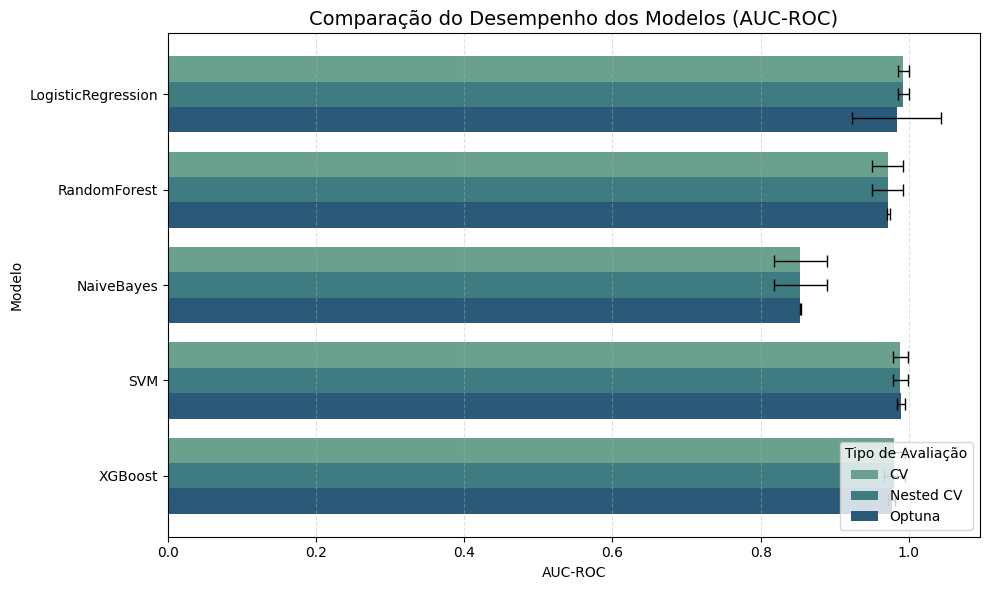

In [304]:
df_list = []
for model in results_optuna.index:
    if model != 'Baseline_Dummy':
        
        df_list.append({'Modelo': model, 'Tipo': 'CV', 'AUC': results_raw.loc[model, 'Média'], 
                        'Desvio': results_raw.loc[model, 'Desvio Padrão']})
        df_list.append({'Modelo': model, 'Tipo': 'Nested CV', 'AUC': results_cv.loc[model, 'Média'], 
                        'Desvio': results_cv.loc[model, 'Desvio Padrão']})
        df_list.append({'Modelo': model, 'Tipo': 'Optuna', 'AUC': results_optuna.loc[model, 'Média'], 
                        'Desvio': results_optuna.loc[model, 'Desvio Padrão']})

df_long = pd.DataFrame(df_list)

# Ordem das barras
tipo_ordem = ['CV', 'Nested CV', 'Optuna']

# Configuração do gráfico
plt.figure(figsize=(10,6))
palette_colors = sns.color_palette("crest", n_colors=3)  # paleta harmônica

# Criando gráfico de barras agrupadas
bar_plot = sns.barplot(
    x='AUC',
    y='Modelo',
    hue='Tipo',
    data=df_long,
    hue_order=tipo_ordem,
    palette=palette_colors,
    ci=None
)

# Adicionando barras de erro bem alinhadas
bar_width = 0.25  # largura relativa de cada barra
for i, model in enumerate(df_long['Modelo'].unique()):
    for j, tipo in enumerate(tipo_ordem):
        auc = df_long[(df_long['Modelo']==model) & (df_long['Tipo']==tipo)]['AUC'].values[0]
        err = df_long[(df_long['Modelo']==model) & (df_long['Tipo']==tipo)]['Desvio'].values[0]
        # posição horizontal das barras: -bar_width, 0, +bar_width
        y_pos = i - bar_width + j*bar_width
        plt.errorbar(
            x=auc,
            y=y_pos,
            xerr=err,
            fmt='none',
            ecolor='black',
            capsize=4,
            lw=1
        )

# Ajustes finais
plt.title('Comparação do Desempenho dos Modelos (AUC-ROC)', fontsize=14)
plt.xlabel('AUC-ROC')
plt.ylabel('Modelo')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.legend(title='Tipo de Avaliação', loc='lower right')
plt.tight_layout()
plt.show()

A análise do gráfico AUC-ROC complementa as avaliações de acurácia, evidenciando que o XGBoost e o SVM se estabelecem como os preditores de maior capacidade discriminativa, ambos atingindo o valor máximo ou próximo do ótimo (na faixa de 0.99 a 1.0) de maneira extremamente robusta, com a convergência dos resultados de CV, Nested CV e Optuna a reforçar que a otimização não trouxe ganhos significativos para esses modelos. 

A Regressão Logística e o Random Forest mantêm o nível de performance elevado (entre 0.98 e 1.0), com as minúsculas barras de erro a validar a consistência já observada pelo baixo desvio padrão, enquanto o NaiveBayes permanece isolado na outra extremidade, confirmando seu desempenho inferior (AUC em torno de 0.83-0.85) em relação aos modelos baseados em árvores e SVM.

## Conclusão

As avaliações de performance demonstraram que a maioria dos modelos alcançou resultados muito altos, com acurácia e AUC-ROC próximos do ótimo, sendo a estabilidade dos resultados confirmada pelo baixo desvio padrão e pela convergência entre as metodologias de validação. O SVM e o XGBoost mantiveram o melhor desempenho, provando ser os mais adequados para a tarefa preditiva, enquanto o NaiveBayes apresentou uma performance inferior consistente. 

No entanto, o nível de excelência alcançado pode sinalizar duas possibilidades: ou os modelos estão realmente capturando a estrutura dos dados de maneira otimizada, ou as features selecionadas são demasiadamente descritivas ou básicas para a classificação. Para discernir essa questão e entender a lógica de decisão por trás dessa alta precisão, a interpretabilidade dos modelos foi igualmente priorizada, com a contribuição individual de cada feature desvendada pela técnica SHAP, o que permite complementar a análise de performance com o entendimento do real mecanismo preditivo dos algoritmos.

## Referências

1. Datasets https://www.ebi.ac.uk/gxa/experiments/E-GEOD-101794/Downloads
2. Transformação Logarítmica https://medium.com/@whzpvictoria/transforma%C3%A7%C3%A3o-logar%C3%ADtmica-nos-dados-quando-utilizar-d1a54da9beab
3. Normalização https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
4. PCA Johnson, R. A., & Wichern, D. W. (2007). Applied Multivariate Statistical Analysis (6th ed.). Pearson Prentice Hall.
5. Inspiração Gráfico PCA 3D https://github.com/mateusjmd/Ilum/tree/main/2025.2/PEST
6. Plotagem Gráficos PCA https://gemini.google.com/app
7. Significância Estatística ASSIS, Janilson Pinheiro de; SOUSA, Roberto Pequeno de; LINHARES, Paulo César Ferreira. Testes de Hipóteses Estatísticas. Mossoró, RN: EdUFERSA, 2020.
8. Significância Biológica LOVE, Michael I.; HUBER, Wolfgang; ANDERS, Simon. Moderated estimation of fold change and dispersion for RNA-seq data with DESeq2. Genome Biology, v. 15, n. 12, p. 550, 2014.
9. Consultas https://gemini.google.com/app
11. SCIKIT-LEARN. StratifiedKFold — scikit-learn 1.3.2 documentation. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold
12. SCIKIT-LEARN. cross_val_score — scikit-learn 1.3.2 documentation. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
13. SCIKIT-LEARN. LogisticRegression — scikit-learn 1.3.2 documentation. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
14. SCIKIT-LEARN. RandomForestClassifier — scikit-learn 1.3.2 documentation. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
15. SCIKIT-LEARN. SVC — scikit-learn 1.3.2 documentation. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
16. SCIKIT-LEARN. GaussianNB — scikit-learn 1.3.2 documentation. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
17. XGBOOST. XGBClassifier — XGBoost documentation. Disponível em: https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier
18. SCIKIT-LEARN. roc_auc_score — scikit-learn 1.3.2 documentation. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
19. OPTUNA. Optuna: A hyperparameter optimization framework. Disponível em: https://optuna.org/
20. SEABORN. barplot — Seaborn documentation. Disponível em: https://seaborn.pydata.org/generated/seaborn.barplot.html
21. MATPLOTLIB. pyplot.bar — Matplotlib documentation. Disponível em: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html
22. CS50. Introduction to Computer Science — Harvard University. Disponível em: https://cs50.harvard.edu/x/
23. CHATGPT. OpenAI. ChatGPT. Disponível em: https://chat.openai.com/
10. <mark>COMPLETAR REFERÊNCIAS</mark>


_Observações:_ A IA foi utilizada como auxilio na identificação das etapas para o tratamento de dados e na elaboração dos códigos para realizar o tratamento, em especial para as formatações exibidas no console, no entendimento e no auxílio dos códigos dos modelos e hiperparâmetros, além de ser utilizado para a plotagem dos gráficos e auxiliar na interpretação dos resultados obtidos.

